# Feature Reduction

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

from collections import namedtuple, Counter
from typing import Set
import itertools
import numpy as np
import matplotlib.pyplot as plt

## Step 0
- You will get a csv file from us. Load it in your language/environment.
- Explore the data in it. Identify features and labels.

In [2]:
data_frame = pd.read_csv('diabetes.csv')

In [3]:
data_frame.dtypes

age        float64
sex        float64
bmi        float64
bp         float64
s1         float64
s2         float64
s3         float64
s4         float64
s5         float64
s6         float64
disease    float64
dtype: object

In [4]:
data_frame

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


## Step 1
- Split your data into training and test set. Use a ratio of 80-20.

In [6]:
training_set, test_set = train_test_split(data_frame, test_size=0.2)
train_X: pd.DataFrame = training_set.drop('disease', axis=1)
train_y = training_set['disease']
    
test_X: pd.DataFrame = test_set.drop('disease', axis=1)
test_y = test_set['disease']

- Use OLS to predict the labels. Report the MSE for training and test set.

In [7]:
regression: LinearRegression = LinearRegression().fit(train_X, train_y)

print('OLS MSE training:', mean_squared_error(train_y, regression.predict(train_X)))
print('OLS MSE test:', mean_squared_error(test_y, regression.predict(test_X)))

OLS MSE training: 2865.3943733468864
OLS MSE test: 2933.6877101175514


## Step 2
- Use Lasso regression to automatically reduce the feature space ($\lambda = 0.1$). Report the MSE for the training and test set.

In [8]:
lasso = Lasso(alpha=0.1).fit(train_X, train_y)

print('Lasso MSE training:', mean_squared_error(train_y, lasso.predict(train_X)))
print('Lasso MSE test:', mean_squared_error(test_y, lasso.predict(test_X)))

Lasso MSE training: 2924.289742302172
Lasso MSE test: 3072.028673982145


## Step 3
- Implement a correlation-based feature selection*. Use 0.6 as a threshold.


In [9]:
correlation_matrix = data_frame.corr()
Correlation = namedtuple('Correlation', ['feature_1', 'feature_2', 'value'])
correlations: Set[Correlation] = set()
for feature_1, feature_2 in itertools.combinations(correlation_matrix.columns, r=2):
    value = correlation_matrix[feature_1][feature_2]
    if value > 0.6:
        # Correlation found
        correlations.add(Correlation(feature_1, feature_2, value))

features_to_remove = set()

while correlations:
    feature_list = []
    for correlation in correlations:
        feature_list.append(correlation.feature_1)
        feature_list.append(correlation.feature_2)
        
    features_sorted_by_correlations = Counter(feature_list).most_common()

    max_feature_count = features_sorted_by_correlations[0][1]
    
    features_with_most_correlations = [feature for feature, count in features_sorted_by_correlations if
                                       count == max_feature_count]
    highest_correlated_feature = None
    correlation_value = 0
    for feature in features_with_most_correlations:
        for feature_1, feature_2, value in correlations:
            if (feature == feature_1 or feature == feature_2) and value > correlation_value:
                highest_correlated_feature = feature
                correlation_value = value

    features_to_remove.add(highest_correlated_feature)

    correlations = {correlation for correlation in correlations if
                    highest_correlated_feature != correlation.feature_1 and highest_correlated_feature != correlation.feature_2}
    
print(features_to_remove) 

{'s2', 's4'}


In [11]:
train_X_reduced = train_X.drop(features_to_remove, axis=1)
test_X_reduced = test_X.drop(features_to_remove, axis=1)

- Train OLS on the reduced feature space. Report the MSE for the training and test set.

In [12]:
regression: LinearRegression = LinearRegression().fit(train_X_reduced, train_y)

print('OLS MSE training:', mean_squared_error(train_y, regression.predict(train_X_reduced)))
print('OLS MSE test:', mean_squared_error(test_y, regression.predict(test_X_reduced)))

OLS MSE training: 2892.851870842755
OLS MSE test: 2904.101944545588


## Step 4
- Implement PCA*. Transform your feature space to 2D.
- Train OLS on the reduced feature space. Report the MSE for the training and test set.

Target: $T = XW$, find $W$

Columns of $W$ are the eigenvectors of $X^TX$

In [13]:
train_X_np = train_X.to_numpy()
eigenvalues, eigenvectors = np.linalg.eig(train_X_np.T @ train_X_np)

# Calculate moste important eigenvectors based on eigenvalues
importance = sorted(enumerate(eigenvalues / sum(eigenvalues)), key=lambda x: x[1], reverse=True)

If $W$ is column-truncated $T_p =XW_p$,

$T$ is a reduced feature space (p-dimensional)

In [14]:
dimensions = 2
important_vec_indices = [index for index, _ in importance[:dimensions]]

w = eigenvectors[important_vec_indices].T

# Reduce feature space
train_X_pca = train_X_np @ w
test_X_pca = test_X.to_numpy() @ w

### Regression

In [15]:
regression: LinearRegression = LinearRegression().fit(train_X_pca, train_y)

print('OLS MSE training:', mean_squared_error(train_y, regression.predict(train_X_pca)))
print('OLS MSE test:', mean_squared_error(test_y, regression.predict(test_X_pca)))

OLS MSE training: 5814.879309541581
OLS MSE test: 6377.741246716916


### Plot 2D reduced feature space

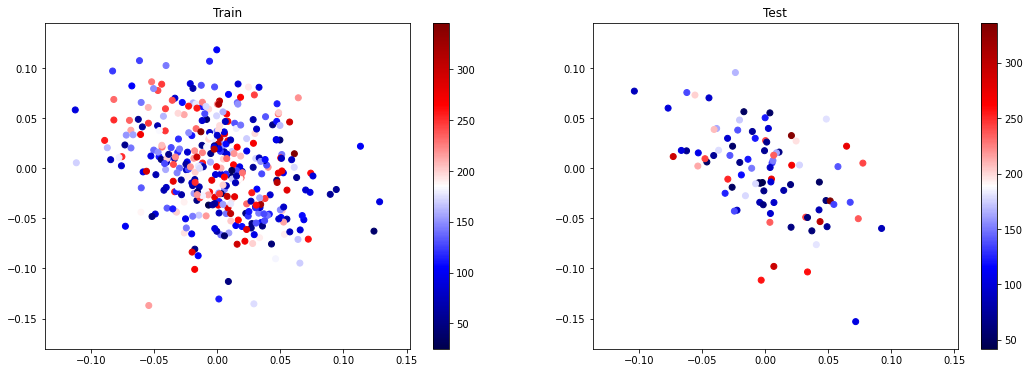

In [24]:
if dimensions == 2:
    min_x = min(train_X_pca[:,0].min(), test_X_pca[:,0].min())
    max_x = max(train_X_pca[:,0].max(), test_X_pca[:,0].max())
    diff_x = max_x - min_x

    min_y = min(train_X_pca[:,1].min(), test_X_pca[:,1].min())
    max_y = max(train_X_pca[:,1].max(), test_X_pca[:,1].max())
    diff_y = max_y - min_y
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1,2,1)
    plt.scatter(*zip(*train_X_pca), c=train_y, cmap='seismic')
    plt.title('Train')
    plt.colorbar()
    
    axes = plt.gca()
    axes.set_xlim([min_x - 0.1 * diff_x, max_x + 0.1 * diff_x])
    axes.set_ylim([min_y - 0.1 * diff_y, max_y + 0.1 * diff_y])
    
    plt.subplot(1,2,2)
    plt.scatter(*zip(*test_X_pca), c=test_y, cmap='terrain')
    plt.title('Test')
    plt.colorbar()
    
    axes = plt.gca()
    axes.set_xlim([min_x - 0.1 * diff_x, max_x + 0.1 * diff_x])
    axes.set_ylim([min_y - 0.1 * diff_y, max_y + 0.1 * diff_y])
    
    plt.show()

### Scree plot

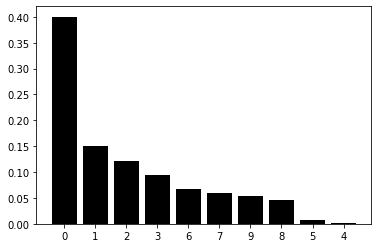

In [29]:
y_pos = np.arange(len(eigenvectors))
plt.bar(y_pos, [y for _, y in importance], color="black")
plt.xticks(y_pos, [x for x, _ in importance])
plt.show()